In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0016908 (max: 1e-06)
	Norm deltaX: 0.00513257, Norm R: 0.753359
	deltaX: 0.00412803 -0.00305002 
	deltaR: 0.312807 -0.685348 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 5.62162e-06 (max: 1e-06)
	Norm deltaX: 0.000487786, Norm R: 0.0711442
	deltaX: 2.09973e-05 -0.000487334 
	deltaR: 0.0682367 -0.0201308 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 1.85594e-08 (max: 1e-06)
	Norm deltaX: 1.58553e-05, Norm R: 0.00235173
	deltaX: 1.04968e-05 -1.18831e-05 
	deltaR: 0.00138254 -0.00190242 

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.000583429 (max: 1e-06)
	Norm deltaX: 0.00446893, Norm R: 1.29466
	deltaX: 0.00439841 -0.000790751 
	deltaR: 0.0326094 -1.29425 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 4.92465e-06 (max: 1e-06)
	Norm deltaX: 0.00064917, Norm R: 0.187883
	deltaX: -3.52428e-05 -0.000648213 
	deltaR: 0.18617 -0.0253164 
CTestEnergyIncr::test() - iteration: 3

[[ 0.00000000e+00  0.00000000e+00]
 [-1.89927923e-02  1.74379530e+01]
 [-2.93193085e-02  2.89795997e+01]
 [-3.07530267e-02  3.80982991e+01]
 [-2.32762923e-02  4.84281697e+01]
 [-7.01914951e-03  6.36334657e+01]
 [ 1.75335401e-02  8.67389423e+01]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1.19745358e+02]
 [ 4.93553781e-02  1

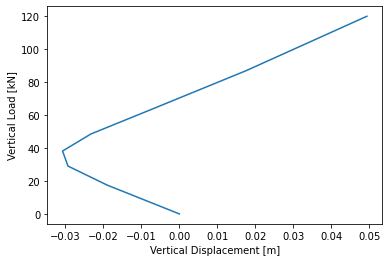

Running Time:  1.7114269733428955  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.38 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.12  #Initial value of lambda (arc length parameter)
spring_stiffness = 35.030


#Geometric and material properties
E1 = 1000000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 6000000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 30 #kN

#Coordinates of the nodes
Lhalf = 11.4
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=50 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 30, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = ops.nodeDisp(2,1)    #abs(ops.nodeDisp(2,2))
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')